In [119]:
import os
from collections import OrderedDict

import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

% matplotlib inline

## Objective: To save a munged GDP to munged_data/un_gdp_constant_mkt

In [120]:
output_path = os.environ['ZERG'] + 'data/output_data/{}'
data_path = os.environ['ZERG'] + 'data/wb/gdp/{}'                                                                  

# Open files
### NY.GDP.PCAP.PP.KD is WDI indicator

    NY = national accounts: income
    
    MKTP = market prices
    
    PCAP = per capita
    
    PP = purchasing power (no PP means not PP)
    
    KD = constant (vs CD = current)
   
### Save output files with aggregates filtered
* gdp market current [] - add code
* gdp market constant [] - fix code
* gdp ppp current [o]
* gdp ppp constant [o]

In [121]:
data_path = os.environ['ZERG'] + 'data/output_data/wb/{}'    

wb_path = os.environ['ZERG'] + 'data/wb/gdp/{}'

In [122]:
# # df_gdp is gdp market constant
# df_gdp_cst_mkt = pd.read_csv(data_path.format('gdp_constant/API_NY.GDP.MKTP.KD_DS2_en_csv_v2.csv', skiprows=4))
# meta_data = pd.read_csv(data_path.format('gdp_constant/Metadata_Country_API_NY.GDP.MKTP.KD_DS2_en_csv_v2.csv'))
                        
# gdp ppp current
gdp_ppp_current = pd.read_csv(wb_path.format('gdp_ppp_current/API_NY.GDP.MKTP.PP.CD_DS2_en_csv_v2.csv'), skiprows=4) # CD for current
meta_data_ppp_curr = pd.read_csv(wb_path.format('gdp_ppp_current/Metadata_Country_API_NY.GDP.MKTP.PP.CD_DS2_en_csv_v2.csv'))
                        
# gdp ppp constant
gdp_ppp_constant = pd.read_csv(wb_path.format('gdp_ppp_constant/API_NY.GDP.MKTP.PP.KD_DS2_en_csv_v2.csv'), skiprows=4) # KD for constant
meta_data_ppp_const = pd.read_csv(wb_path.format('gdp_ppp_constant/Metadata_Country_API_NY.GDP.MKTP.PP.KD_DS2_en_csv_v2.csv'))

### Reusable functions

In [123]:
def filter_non_countries(_df, _metadata):
    '''
    _df : pd.DataFrame
        either income or population data
        
    _metadata : pd.DataFrame
        metadata on a list of entries including countries and non-countries 
        data source is from the World Bank
        has IncomeGroup column that is not null for countries (217)
    '''
    # Country Code in both dataframes
    _merged = _df.merge(_metadata, on='Country Code')
    # non-countries have no IncomeGroup
    non_country_mask = _merged['IncomeGroup'].isnull()
    merged_country_only = _merged[~non_country_mask]
    return merged_country_only

def select_relevant_cols(_df):
    # returns df with 'Country Name', 'Country Code' and all years (1960 to 2016)
    _cols = ['Country Name'] + ['Country Code'] + [str(yr) for yr in range(1960, 2017)]
    return _df[_cols]

In [124]:
convert_to_float = lambda _df: _df.astype(float)


def drop_non_years(_df):
    def _is_year(_y):
        try:
            float(_y)
            return True
        except ValueError:
            return False
    return _df[[x for x in _df.columns if _is_year(x)]] 

def set_col_as_index(_df, _col_name):
    return _df.set_index(_col_name)

# set year as columns name
# this is removed in csv data
def set_col_idx_name(_df, col_idx_name='year'):
    _df.columns.name = col_idx_name
    return _df

def add_iso_column(_df):
    return _df.assign(iso=_df['Country Code'])  
    
# not used, add_iso_column for all sources
def add_iso_column_all(_df, _country_name_col, data_source='general'):
    # uses iso_map (global dict)
    map_to_iso = lambda c: iso_map[c] if iso_map.get(c) else c # c for country name
    map_to_iso_un = lambda c: iso_map_un_na[c] if iso_map_un_na.get(c) else c # c for country name

    if 'iso' in _df.columns:
        pass
    elif data_source is 'un':
        v_map = np.vectorize(map_to_iso_un)
        assigned = _df.assign(iso=v_map(_df[_country_name_col]))
    else:
        v_map = np.vectorize(map_to_iso)
        assigned = _df.assign(iso=v_map(_df[_country_name_col]))
    return assigned

### prep data

In [125]:
def prep_data(_df):
    _iso_added = set_col_as_index(add_iso_column(_df), 'iso')
    _col_named = set_col_idx_name(_iso_added)
    _non_years_dropped = drop_non_years(_col_named)
    _null_years_dropped = _non_years_dropped.dropna(axis=1, how='all')
    return _null_years_dropped

def save_to_csv(_df, _output_file_name):
    _df.to_csv(_output_file_name)

## Testing 

In [126]:
def test_meta_data_looks_good(_meta_data):
    num_countries, num_aggregates = meta_data_ppp_const['IncomeGroup'].isnull().value_counts() # 217 False (countries) # 46 nan
    assert num_countries == 217
    assert num_aggregates == 46
    assert len(_meta_data['IncomeGroup'].unique()) == 5
        # expected IncomeGroup -> 
        # array(['High income', 'Low income', 'Lower middle income',
        #   'Upper middle income', nan], dtype=object)
  
# drop non years
# set col index name as 'years'
def test_add_iso_column(_df):
    assert 'iso' not in _df.columns.tolist()
    iso_added = add_iso_column(_df)
    assert 'iso' in iso_added.columns.tolist()
    assert iso_added.shape[1] - _df.shape[1] == 1
    
def test_set_col_as_index(_df):
    iso_indexed = set_col_as_index(_df, 'iso')
    assert len([x for x in iso_indexed.index.tolist() if len(x)!=3]) == 0
    
def test_set_col_idx_name(_df):
    col_named = set_col_idx_name(_df, 'years')
    assert col_named.columns.name == 'years'

def test_drop_non_years(_df):
    # years 1960 to 2017
    _dropped = drop_non_years(_df)
    assert _dropped.columns.tolist() == [str(x) for x in range(1960,2018)]
    
# def set_col_as_index(_df, _col_name):
#     return _df.set_index(_col_name)

def test_convert_to_float(_df):
    converted = convert_to_float(_df)
    pass

### Pipeline to filter aggregates (not countries)

1. filter_non_countries(dataframe, meta_data)

2. save filtered data to csv! (in output_data)

## 1. gdp constant market (add here)

In [127]:
# df_gdp_countries = filter_non_countries(df_gdp_cst_mkt, meta_data)
# df_gdp_countries.shape

## 2. gdp current market (add here)

## 3. gdp constant ppp

### testing suites here

### filtering non countries

In [128]:
test_meta_data_looks_good(meta_data_ppp_const)

# main filtering
filtered_gdp_ppp_const = filter_non_countries(gdp_ppp_constant, meta_data_ppp_const)

### munging data (add iso, set column name, index iso, drop non years, drop null columns)

In [129]:
test_add_iso_column(filtered_gdp_ppp_const)
gdp_iso_added = add_iso_column(filtered_gdp_ppp_const)

In [130]:
test_set_col_as_index(gdp_iso_added)
gdp_iso_indexed= set_col_as_index(gdp_iso_added, 'iso')

In [131]:
test_set_col_idx_name(gdp_iso_indexed)
gdp_col_named = set_col_idx_name(gdp_iso_indexed)

In [132]:
test_drop_non_years(gdp_col_named)
dropped = drop_non_years(gdp_col_named)
dropped_null = dropped.dropna(axis=1, how='all')

In [133]:
# dropped_null.to_csv(data_path.format('wb_gdp_ppp_constant_countries.csv'))

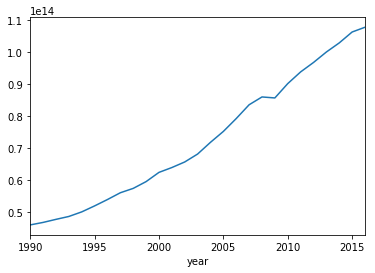

In [134]:
dropped_null.sum(axis=0).plot()

In [135]:
prepped = prep_data(filtered_gdp_ppp_const)
save_to_csv(prepped, data_path.format('wb_gdp_ppp_constant_prepped.csv'))

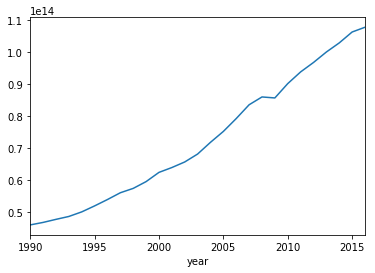

In [136]:
prepped.sum(axis=0).plot()

In [137]:
assert prepped.shape == dropped_null.shape

## 4. gdp current PPP

In [138]:
prepped_ppp_current = prep_data(gdp_ppp_current)
prepped_ppp_current.to_csv(data_path.format('wb_gdp_ppp_current_prepped.csv'))